# Calculation of N14 A$\beta$ concentration using N15 labeled A$\beta$ and MALDI-MS

## Abstract
Alzheimer's Disease (AD) is already a huge problem in today's society and is projected to become even worse in near future. A hallmark of AD is the formation of amyloid plaques, these mainly consist of a protein called amyloid beta (a.k.a. abeta or A$\beta$). Much is still unkown about the formation of these plaques, both in terms of cause and mechanism. To help elucidate answers in these questions I'm studying the solubility of abeta, i.e. at what concentration does this protein aggregate and what intrinsic and extrinsic factors modulate this? An essential part of this is of course quantifying the concentration of abeta under different conditions but quantifying protein concentrations can be hard. As abeta doesn't contain any tryptophans and only 1 tyrosine, concentration determination by absorbance only works at quite high concentrations. Thus another method is needed, here I utilize matrix-assisted laser desorption ionization mass spectroscopy (MALDI-MS) to get a ratio of peak intensities from abeta and a chemically identical version of abeta with an extra neutron that I have added to the sample at a known concentration. As these N14 abeta peptides and N15 abeta peptides are chemically identical they will ionize equally in MS but the extra neutron will separate them and the ratio of peak intensities will be equal to the concentration ratio between them. As this quickly becomes very tedious work for many samples this notebook automates the process by reading in peak intensities from exported excel files, matching them to correct cleavage product froms protease digestion, pairs corrseponding N14 and N15 peaks, divides them with each other generating ratios, sorts these by user defined indices and finally plots the results. As example data the adsorption of abeta to pipette tips is used.

Overview of workflow before this notebook:
![workflow](drawing.png)

## Import packages & data


In [32]:
import pandas as pd #for data handling
import matplotlib.pyplot as plt #for plotting
import string #for generating well names
import numpy as np 
plt.rcParams["figure.dpi"] = 300

In [8]:
list_of_data1 = pd.read_excel('masslist1.xlsx', sheet_name=None, header=2) #create a dictionary of pandas dataframes with each data frame corresponding to a sheet in the excel file.
list_of_data2 = pd.read_excel('masslist2.xlsx', sheet_name=None, header=2) #create a dictionary of pandas dataframes with each data frame corresponding to a sheet in the excel file.
list_of_data3 = pd.read_excel('masslist3.xlsx', sheet_name=None, header=2) #create a dictionary of pandas dataframes with each data frame corresponding to a sheet in the excel file.
list_of_data=list_of_data1|list_of_data2|list_of_data3

Below is a switch for dev_mode. When this is true much more output will be generated which can be nice for development/troubleshooting. When it is set to false the notebook becomes much cleaner. 

In [9]:
dev_mode = True

## Define peaks of interest
Here is the theoretical peak lists for A$\beta_{m1-42}$ digested with either AspN or trypsin. Generated with [GPMAW](https://www.gpmaw.com/).

In [10]:
ABm1_42_aspN_N14_peaks = [905.39,1905.91]
ABm1_42_aspN_N15_peaks = [917.36,1927.85]

## Define the main function
This function finds the relevant peaks from the big collection of peaks generated by the flexAnalysis software. For each collection of peaks (each spot on the MALDI plate) it looks for peaks that are +- a specified fault tolerance from the theoretical peaks defined above. If it finds both a peak close to the theoretical value for an N14 fragment and a peak for the corresponding N15 fragment, it goes on to look for isotope peaks close to these (i.e. peaks which are almost exactly 1 Da away from the main peak). It then takes the sum of the intensities of the N14 fragment's main peak and it's associated isotope peaks divided by the sum of the intensities of the corresponding N15 fragment's peaks. Lastly it adds this ratio to a list as well as which spot and fragment it was and continue to look for the next fragment. When it has looked for all fragments in all spectra it spits an indexed pandas data frame with all the ratios.

![Function-schematic](ratio-maker2-schematic.png)

In [11]:
def ratio_maker2(input_data,n14_peaks,n15_peaks,fault_tolerance):   #for ratios of all isotope peaks summed.
    n14=n14_peaks
    n15=n15_peaks
    values=[] # this list will gather all calculated ratios as the for loop below works through the sheets in the input data.
    index_list=[] # this will simultanously as the above gather well name and peak number to keep track on what ratios belong to what.
    all_N14 = {} # this collects all isotope peaks used for the sums (and by extension the ratios)
    all_N15 = {} # same as above 
    for x in input_data.keys():        
        df=input_data[x] # define the current dataframe as df for convenience 
        for i in range(len(n14)):
            tmp = df.loc[((df["m/z"]>(n14[i]-fault_tolerance)) & (df["m/z"]<(n14[i]+fault_tolerance)) |
               (df["m/z"]>(n15[i]-fault_tolerance)) & (df["m/z"]<(n15[i]+fault_tolerance))), ] 
            #makes a dataframe with only the peaks from masslist.xlsx that are within the fault tolerance from the theoretical cleavage peaks
            if len(tmp) > 2:
                tmp=tmp.sort_values('SN',ascending=False).iloc[0:2]
                # sometimes there is extra peaks very close to the ones of interest so this hopefully removes them
                # by only keeping the 2 with highest signal to noise ratio 
            if len(tmp) == 2:
                n14_isotopes= []
                # If tmp is exactly 2 rows long then we should only have the main N14 and N15 peak           
                n14_isotopes.append(df.loc[((df["m/z"]>(n14[i]-fault_tolerance)) & (df["m/z"]<(n14[i]+fault_tolerance))),])
                # we then add the peak that are 1 +- 0.1 Da heavier then the main N14 peak and then the one 1 Da heavier then that one and so on 
                # until there is no more peaks that are 1 +- 0.1 Da heavier. This collects all the isotope peaks to the right of the main peak. 
                a=1
                while (not df.loc[((df["m/z"]>(n14_isotopes[0].iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(n14_isotopes[0].iloc[0]['m/z']+a+0.1))),].empty):
                    n14_isotopes.append(df.loc[((df["m/z"]>(n14_isotopes[0].iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(n14_isotopes[0].iloc[0]['m/z']+a+0.1))),])
                    a+=1 
                # we then do the same in the other direction
                a=1
                while (not df.loc[((df["m/z"]>(n14_isotopes[0].iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(n14_isotopes[0].iloc[0]['m/z']-a+0.1))),].empty):
                    n14_isotopes.append(df.loc[((df["m/z"]>(n14_isotopes[0].iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(n14_isotopes[0].iloc[0]['m/z']-a+0.1))),])
                    a+=1
                # if we found any isotope peaks we concatenate them into one dataframe
                if len(n14_isotopes)>1:
                    df_14=pd.concat(n14_isotopes)
                # otherwise we just use the main peak initially found
                else:
                    df_14=n14_isotopes[0]
                # then we do the same for N15
                n15_isotopes= []
                n15_isotopes.append(df.loc[((df["m/z"]>(n15[i]-fault_tolerance)) & (df["m/z"]<(n15[i]+fault_tolerance))),])
                a=1
                while (not df.loc[((df["m/z"]>(n15_isotopes[0].iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(n15_isotopes[0].iloc[0]['m/z']+a+0.1))),].empty):
                    n15_isotopes.append(df.loc[((df["m/z"]>(n15_isotopes[0].iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(n15_isotopes[0].iloc[0]['m/z']+a+0.1))),])
                    a+=1 
                a=1
                while (not df.loc[((df["m/z"]>(n15_isotopes[0].iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(n15_isotopes[0].iloc[0]['m/z']-a+0.1))),].empty):
                    n15_isotopes.append(df.loc[((df["m/z"]>(n15_isotopes[0].iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(n15_isotopes[0].iloc[0]['m/z']-a+0.1))),])
                    a+=1
                if len(n15_isotopes)>1:
                    df_15=pd.concat(n15_isotopes) 
                else:
                    df_15=n15_isotopes[0]
                # then we sum all the intensities of the N14 peaks and divide that by the sum of the N15 peaks. These ratios are collected in the list "values"
                values.append((df_14['Intens.'].sum()/df_15['Intens.'].sum()))
                # we then add what well number and peak we are currently at.
                index_list.append((x.split("_")[-2],str(n14[i]).split('.')[0]))
                # the two lines below here fill up a dictionary each with all collected isotope peaks and their signal to noise, intensities and so on.
                # for the possibility to inspect what was done.
                all_N14[index_list[-1]]=df_14
                all_N15[index_list[-1]]=df_15
    # we then make a dataframe of the ratios
    data = pd.DataFrame({'Ratio':values})
    # give it a reasonable index
    data.index=pd.MultiIndex.from_tuples(index_list, names=["Well","peak"])
    # and return it all
    return data,all_N14,all_N15

In [12]:
ratios_way2,all_N14,all_N15 = ratio_maker2(list_of_data,ABm1_42_aspN_N14_peaks,ABm1_42_aspN_N15_peaks,0.3) #uses the function defined above
if dev_mode:
    print(ratios_way2.index) # just to see which wells and peaks were included as a guide to if fault tolerance should be increased or decreased.

MultiIndex([( 'C5',  '905'),
            ('C10',  '905'),
            ('C15',  '905'),
            ( 'C6',  '905'),
            ('C11',  '905'),
            ('C16',  '905'),
            ( 'C7',  '905'),
            ('C12',  '905'),
            ('C17',  '905'),
            ( 'C8',  '905'),
            ('C13',  '905'),
            ('C18',  '905'),
            ('C14',  '905'),
            ( 'F6',  '905'),
            ( 'F6', '1905'),
            ( 'F7',  '905'),
            ( 'F8',  '905'),
            ( 'F9',  '905'),
            ('F10',  '905'),
            ( 'F1',  '905'),
            ( 'F1', '1905'),
            ( 'F2',  '905'),
            ( 'F3',  '905'),
            ( 'F4',  '905'),
            ( 'F5',  '905'),
            ( 'L1',  '905'),
            ( 'L2',  '905'),
            ( 'L3',  '905'),
            ( 'L3', '1905'),
            ( 'L4',  '905'),
            ( 'L5',  '905')],
           names=['Well', 'peak'])


Export selected peaks as .ods files for transparency and troubleshooting.

In [13]:
Excelwriter = pd.ExcelWriter("all_N14.ods",engine="odf")
for x in all_N14:
    all_N14[x].to_excel(Excelwriter, sheet_name=str(x), index=False)
Excelwriter.save()

Excelwriter = pd.ExcelWriter("all_N15.ods",engine="odf")
for x in all_N15:
    all_N15[x].to_excel(Excelwriter, sheet_name=str(x), index=False)
Excelwriter.save()

## Generate new multi index
Above we get the data organized by well name and peak but it's much more convenient when choosing what to plot and so on to have it organized by names we choose, like sample names and replicate number. To do this we need a conversion table that translates well name to sample. As the samples used in this notebook are spotted on a 384 well MALDI plate (see below) we start with generating a list of all the well names in a this plate (A1 to P24).
![384_WELL_PLATE](384_WELL_PLATE.png)

In [14]:
well_names=[]
for x in string.ascii_uppercase[0:16]:
    for i in range(1,25):
        well_names.append(x+str(i))

Below we are generating a sample list by iterating over different properties of our samples, such as tip brand, number of tips used and replicate number.

In [16]:
samples1 = ['Sar.']
samples2 = [str(x) for x in range(1,6)]
reps = ["1","2","3"]

samples_220105=[]
for x in samples1:
    for y in reps:    
        for z in samples2:
            samples_220105.append(x+'_'+z+'_'+y)

            
samples1 = ['Epp.DNA','Axy.']
samples2 = [str(x) for x in range(1,6)]

samples_220107=[]
#for y in reps:
for x in samples1:
    for z in samples2:
        samples_220107.append(x+'_'+z)

        
samples1 = ['Epp.Prot.']
samples2 = [str(x) for x in range(1,6)]

samples_220212=[]
#for y in reps:
for x in samples1:
    for z in samples2:
        samples_220212.append(x+'_'+z)

samples=samples_220105+samples_220107+samples_220212
if dev_mode:
    print(samples)    

['Sar._1_1', 'Sar._2_1', 'Sar._3_1', 'Sar._4_1', 'Sar._5_1', 'Sar._1_2', 'Sar._2_2', 'Sar._3_2', 'Sar._4_2', 'Sar._5_2', 'Sar._1_3', 'Sar._2_3', 'Sar._3_3', 'Sar._4_3', 'Sar._5_3', 'Epp.DNA_1', 'Epp.DNA_2', 'Epp.DNA_3', 'Epp.DNA_4', 'Epp.DNA_5', 'Axy._1', 'Axy._2', 'Axy._3', 'Axy._4', 'Axy._5', 'Epp.Prot._1', 'Epp.Prot._2', 'Epp.Prot._3', 'Epp.Prot._4', 'Epp.Prot._5']


Use the well names and sample names to create a conversion table for well name to sample name.

In [18]:
#remember non-inclusive end-index!
well_names_to_samples = list(zip(well_names[well_names.index('C5'):well_names.index('C20')],
    samples[samples.index('Sar._1_1'):samples.index('Epp.DNA_1')]))

well_names_to_samples.extend(
      list(zip(well_names[well_names.index('F1'):well_names.index('F11')],
    samples[samples.index('Epp.DNA_1'):samples.index('Epp.Prot._1')])))

well_names_to_samples.extend(
      list(zip(well_names[well_names.index('L1'):well_names.index('L6')],
    samples[samples.index('Epp.Prot._1')::])))

well_names_to_samples = dict(well_names_to_samples)
if dev_mode:
    print(well_names_to_samples)

{'C5': 'Sar._1_1', 'C6': 'Sar._2_1', 'C7': 'Sar._3_1', 'C8': 'Sar._4_1', 'C9': 'Sar._5_1', 'C10': 'Sar._1_2', 'C11': 'Sar._2_2', 'C12': 'Sar._3_2', 'C13': 'Sar._4_2', 'C14': 'Sar._5_2', 'C15': 'Sar._1_3', 'C16': 'Sar._2_3', 'C17': 'Sar._3_3', 'C18': 'Sar._4_3', 'C19': 'Sar._5_3', 'F1': 'Epp.DNA_1', 'F2': 'Epp.DNA_2', 'F3': 'Epp.DNA_3', 'F4': 'Epp.DNA_4', 'F5': 'Epp.DNA_5', 'F6': 'Axy._1', 'F7': 'Axy._2', 'F8': 'Axy._3', 'F9': 'Axy._4', 'F10': 'Axy._5', 'L1': 'Epp.Prot._1', 'L2': 'Epp.Prot._2', 'L3': 'Epp.Prot._3', 'L4': 'Epp.Prot._4', 'L5': 'Epp.Prot._5'}


Make a new multi index from this conversion table.

In [19]:
#New multi index
new_index=[]
for x in ratios_way2.index:
    new_index.append((well_names_to_samples[x[0]].split('_')[0],
                       well_names_to_samples[x[0]].split('_')[1],
                       #well_names_to_samples[x[0]].split('_')[2],
                       x[1]))
if dev_mode:
    print(*new_index, sep = "\n")

('Sar.', '1', '905')
('Sar.', '1', '905')
('Sar.', '1', '905')
('Sar.', '2', '905')
('Sar.', '2', '905')
('Sar.', '2', '905')
('Sar.', '3', '905')
('Sar.', '3', '905')
('Sar.', '3', '905')
('Sar.', '4', '905')
('Sar.', '4', '905')
('Sar.', '4', '905')
('Sar.', '5', '905')
('Axy.', '1', '905')
('Axy.', '1', '1905')
('Axy.', '2', '905')
('Axy.', '3', '905')
('Axy.', '4', '905')
('Axy.', '5', '905')
('Epp.DNA', '1', '905')
('Epp.DNA', '1', '1905')
('Epp.DNA', '2', '905')
('Epp.DNA', '3', '905')
('Epp.DNA', '4', '905')
('Epp.DNA', '5', '905')
('Epp.Prot.', '1', '905')
('Epp.Prot.', '2', '905')
('Epp.Prot.', '3', '905')
('Epp.Prot.', '3', '1905')
('Epp.Prot.', '4', '905')
('Epp.Prot.', '5', '905')


Apply the new index to the dataframe with ratios.

In [20]:
ratios_way2.index = pd.MultiIndex.from_tuples(new_index,names=["brand","# of tubes","peak"])

And now we have the data organized by sample properties instead!

In [21]:
if dev_mode:
    print(ratios_way2)

                              Ratio
brand     # of tubes peak          
Sar.      1          905   0.589975
                     905   0.459755
                     905   0.390208
          2          905   0.356929
                     905   0.185237
                     905   0.367718
          3          905   0.229471
                     905   0.281567
                     905   0.201155
          4          905   0.115182
                     905   0.100286
                     905   0.168395
          5          905   0.088421
Axy.      1          905   0.860945
                     1905  0.327289
          2          905   0.581262
          3          905   0.616301
          4          905   0.464070
          5          905   0.359760
Epp.DNA   1          905   0.760430
                     1905  0.294673
          2          905   0.651779
          3          905   0.651710
          4          905   0.681125
          5          905   0.566532
Epp.Prot. 1          905   0

## Plotting the data


Start by figuring out how you want to filter/group/etc. the data. Then there is a function for inserting labels and finally it is plotted in some different ways.

To include $LaTeX$ code in titles preface your string with an r, like this: `r'bla bla $<LaTeX code here>$ bla'`. 

In [44]:
p = '905'
ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Axy.',axis=0)

Ratio
brand # of tubes          
Axy.  1           0.860945
      2           0.581262
      3           0.616301
      4           0.464070
      5           0.359760

In [24]:
def add_value_labels(ax, spacing=5): #credit to this function goes to "justfortherec", see: https://stackoverflow.com/a/48372659
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


<Figure size 1800x1200 with 0 Axes>

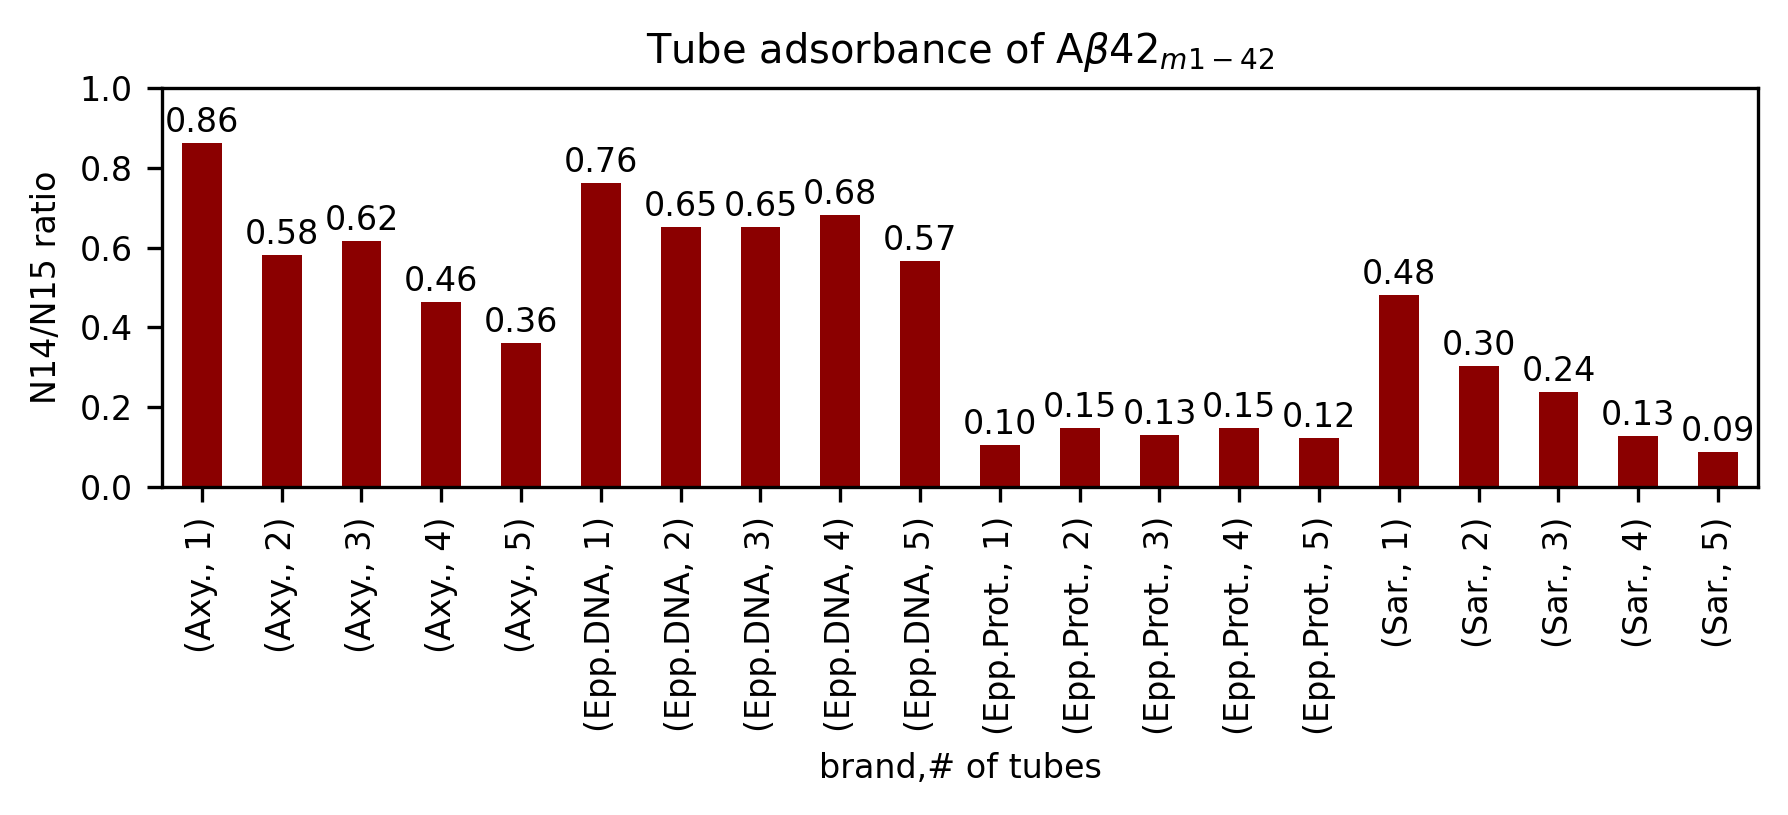

In [39]:
plt.figure()
plt.rcParams.update({'font.size':8})

ax = ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().plot(kind='bar',
                                                   #yerr=ratios_way2.groupby("# of tubes").sem(),
                                                   color='darkred')
ax.set_title(r'Tube adsorbance of A$\beta42_{m1-42}$')
#ax.set_xlabel('Sample')
ax.set_ylabel('N14/N15 ratio')
plt.tight_layout()
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(5)
add_value_labels(ax,1)
plt.ylim(0,1)
ax.get_legend().remove()
plt.savefig("tube_abs_ratios.svg")
plt.savefig("tube_abs_ratios.pdf")

In [67]:
def plotter(data,name,y_axis):
    plt.figure()
    plt.rcParams.update({'font.size':8})

    ax = data.plot(kind='bar',
                                                       #yerr=ratios_way2.groupby("# of tubes").sem(),
                                                       color='darkred')
    ax.set_title(r'Tube adsorbance of A$\beta42_{m1-42}$')
    #ax.set_xlabel('Sample')
    ax.set_ylabel(y_axis)
    plt.tight_layout()
    ax = plt.gca() #you first need to get the axis handle
    ax.set_aspect(5)
    add_value_labels(ax,1)
    plt.ylim(0,1)
    ax.get_legend().remove()
    plt.savefig(name+'.svg')
    plt.savefig(name+'.pdf')

In [62]:
data1=ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Sar.',axis=0)
data2=ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Axy.',axis=0)
data3=ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Epp.DNA',axis=0)
data4=ratios_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Epp.Prot.',axis=0)
plots=[data1,data2,data3,data4]
names=['Sarstedt tubes','Axygen tubes','Eppendorf DNA LoBind tubes','Eppendorf Protein LoBind tubes']

<Figure size 1800x1200 with 0 Axes>

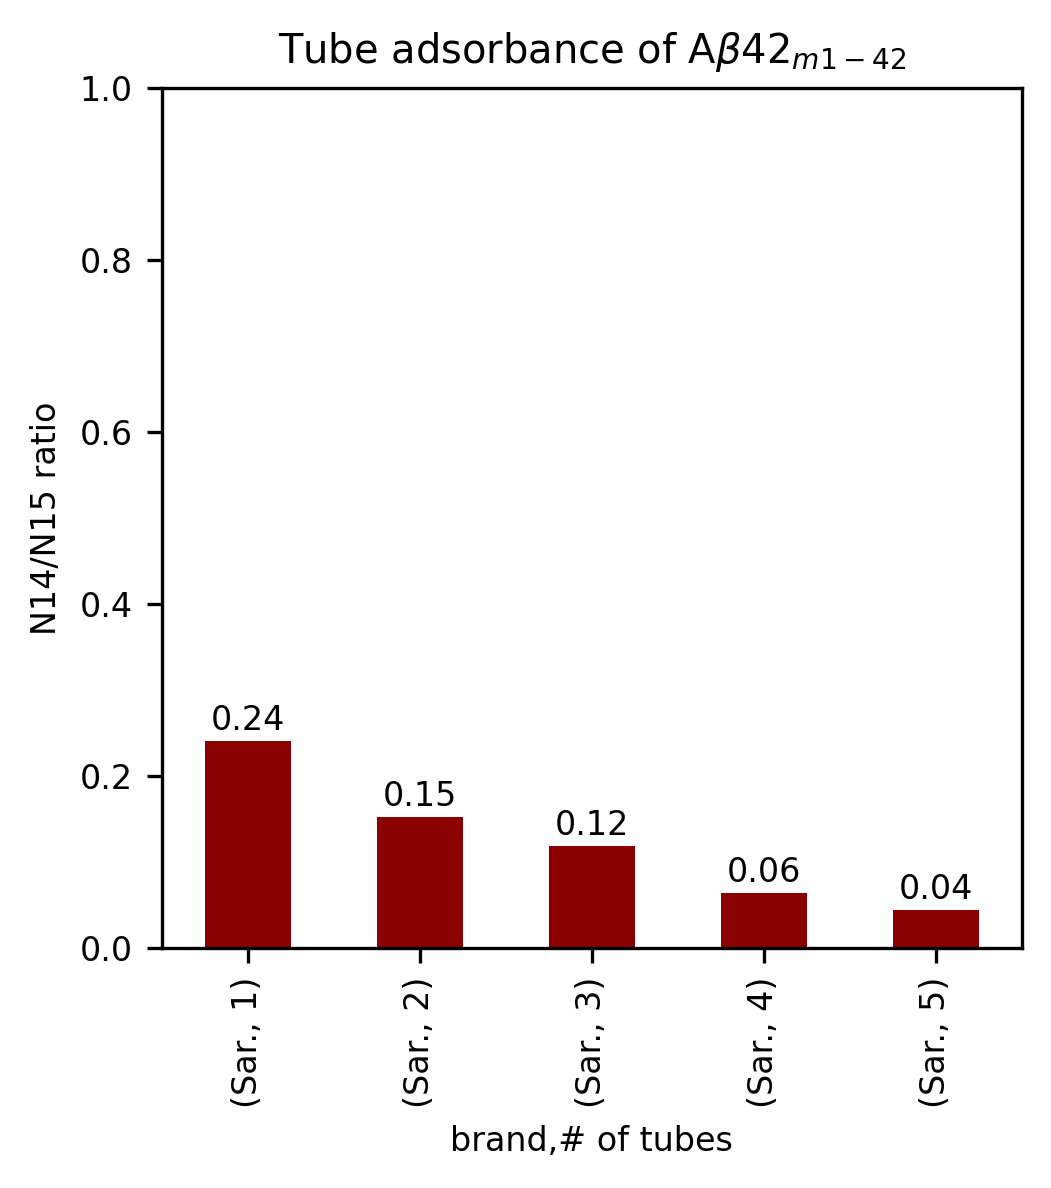

<Figure size 1800x1200 with 0 Axes>

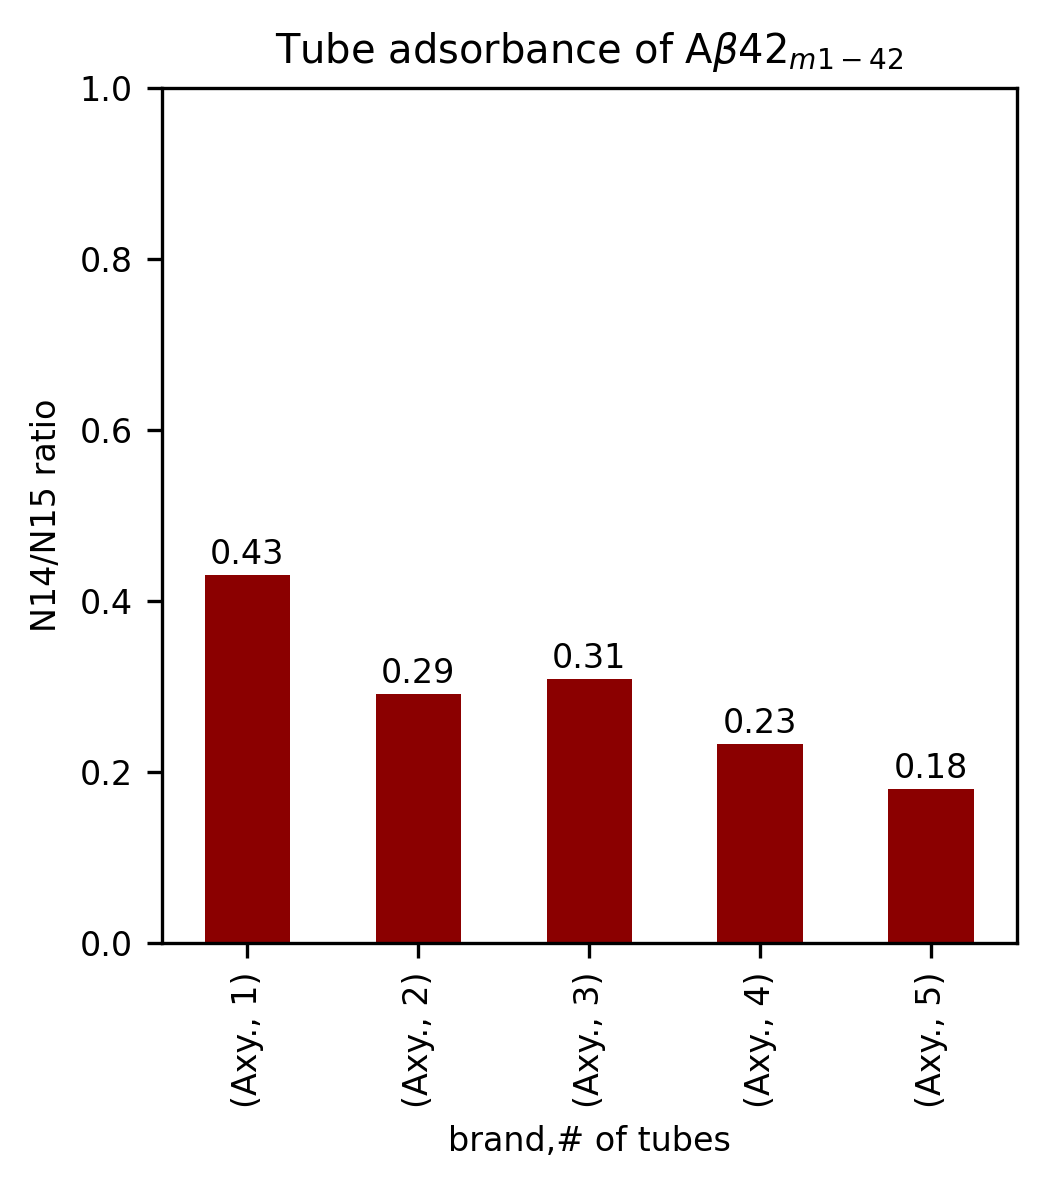

<Figure size 1800x1200 with 0 Axes>

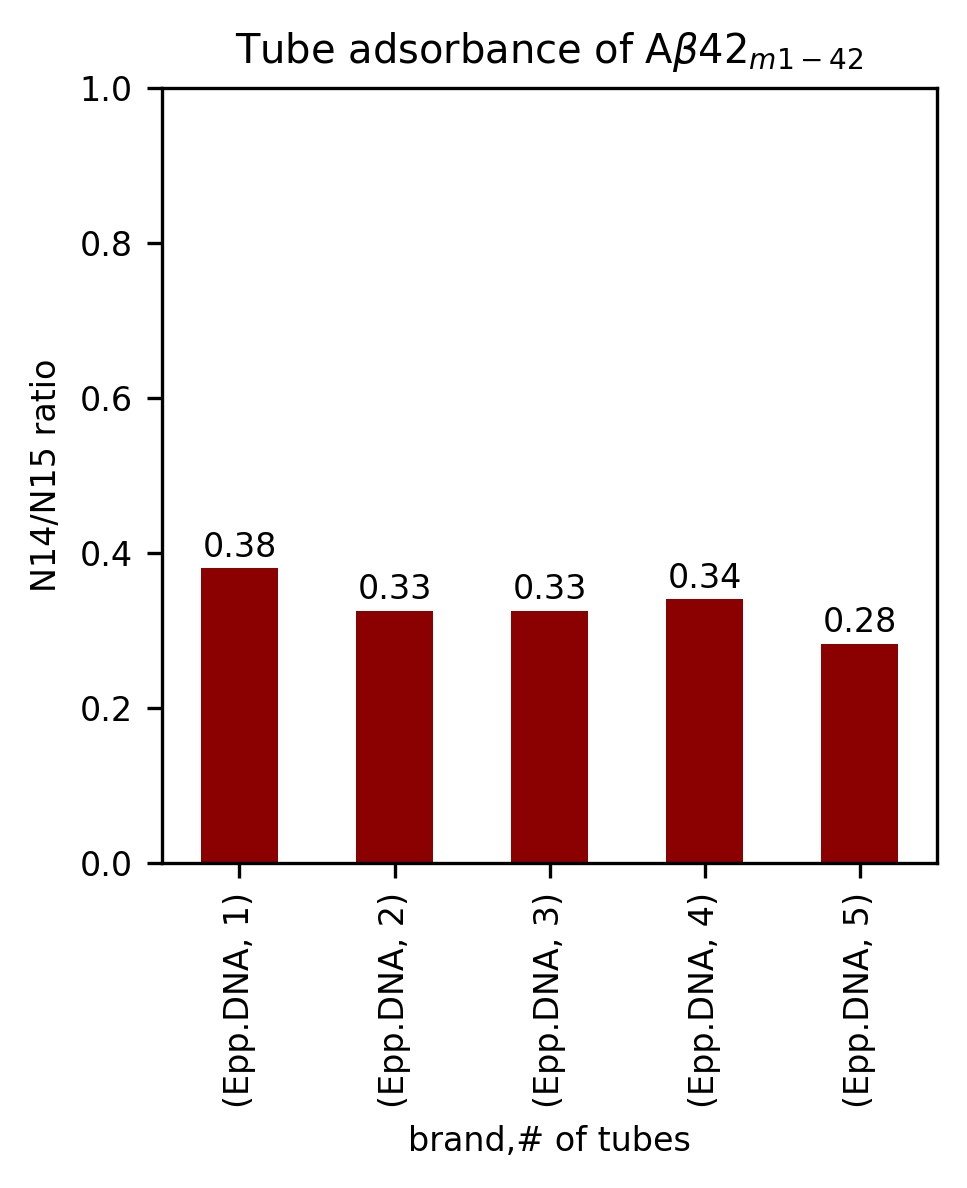

<Figure size 1800x1200 with 0 Axes>

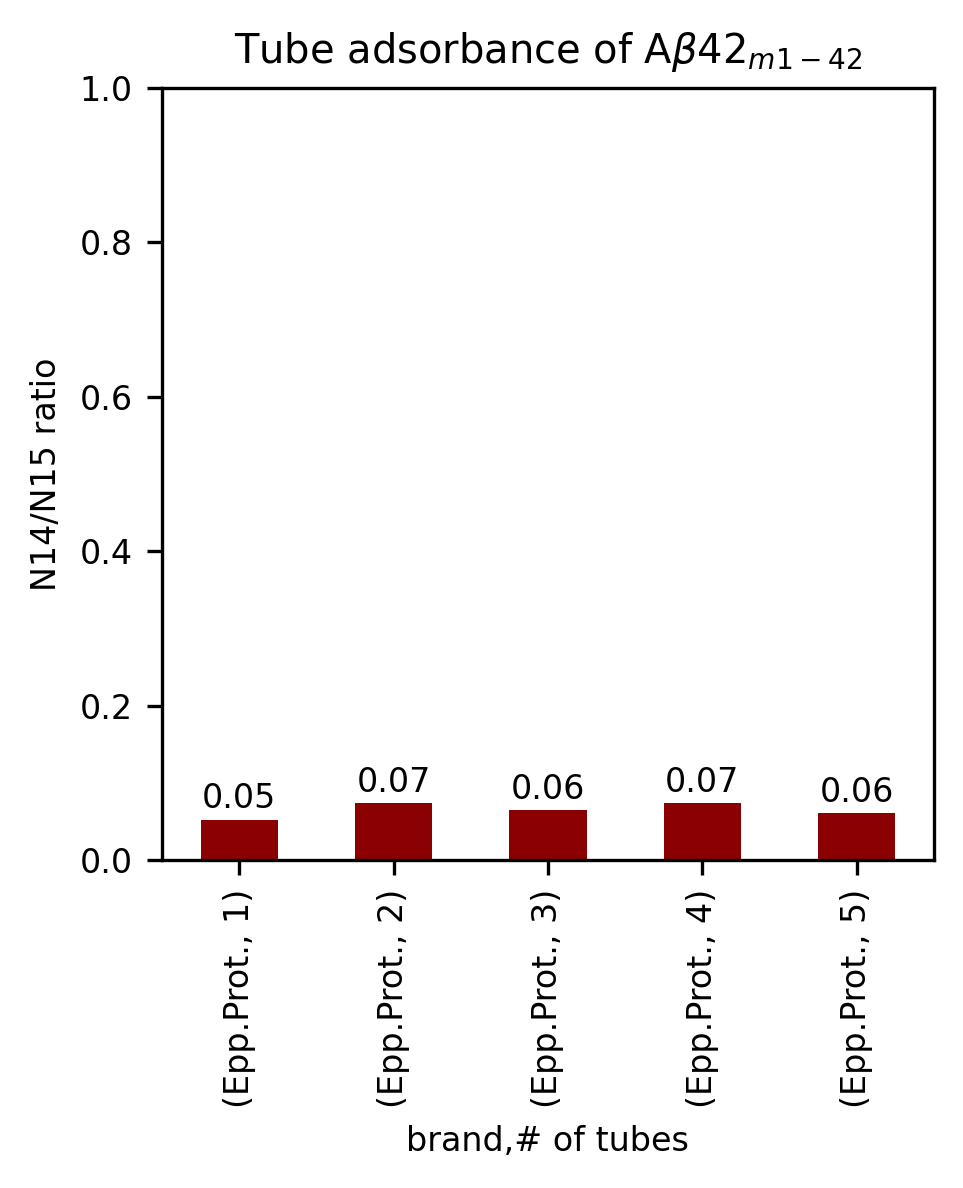

In [68]:
i=0
for x in plots:
    plotter(x,names[i],'N14/N15 ratio')
    i+=1

### Concentrations
While it is good to see the ratios (too high or too low ratios would not be particularly trustworthy), concentration is what we are really after so below I convert the ratios to concentrations. In this case I spiked the N14 samples with a final conc of 0.49 µM N15 labeled $A{\beta}_{m1-42}$, but this spiking also diluted the sample a bit so to get the initial N14 concentration, $c_{N14}$ I calculate in the following way:
$$c_{N14} = \frac{\sum(I_{N14})}{\sum(I_{N15})}*c_{N15}*\frac{V_2}{V_1}$$

Where $I_{N14}$ and $I_{N15}$ are the peak intensities of the N14 and N15 peaks respectively, $c_{N15}$ is the N15 concentration after spiking and $V_2$ and $V_1$ are the total volumes after and before the spiking respectively. For this particular case the volumes were 205 and 200 µl so to convert my ratios to concentrations I have to multiply them with $0.49*1.025=0.5$.

In [64]:
conc_way2 = ratios_way2 * 0.5
if dev_mode:
    print(conc_way2)

                              Ratio
brand     # of tubes peak          
Sar.      1          905   0.294988
                     905   0.229878
                     905   0.195104
          2          905   0.178465
                     905   0.092618
                     905   0.183859
          3          905   0.114735
                     905   0.140784
                     905   0.100577
          4          905   0.057591
                     905   0.050143
                     905   0.084197
          5          905   0.044210
Axy.      1          905   0.430472
                     1905  0.163644
          2          905   0.290631
          3          905   0.308151
          4          905   0.232035
          5          905   0.179880
Epp.DNA   1          905   0.380215
                     1905  0.147337
          2          905   0.325889
          3          905   0.325855
          4          905   0.340562
          5          905   0.283266
Epp.Prot. 1          905   0

In [65]:
data1=conc_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Sar.',axis=0)
data2=conc_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Axy.',axis=0)
data3=conc_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Epp.DNA',axis=0)
data4=conc_way2.query("peak == @p").groupby(['brand','# of tubes']).mean().filter(like='Epp.Prot.',axis=0)
plots=[data1,data2,data3,data4]
names=['Sarstedt tubes','Axygen tubes','Eppendorf DNA LoBind tubes','Eppendorf Protein LoBind tubes']

<Figure size 1800x1200 with 0 Axes>

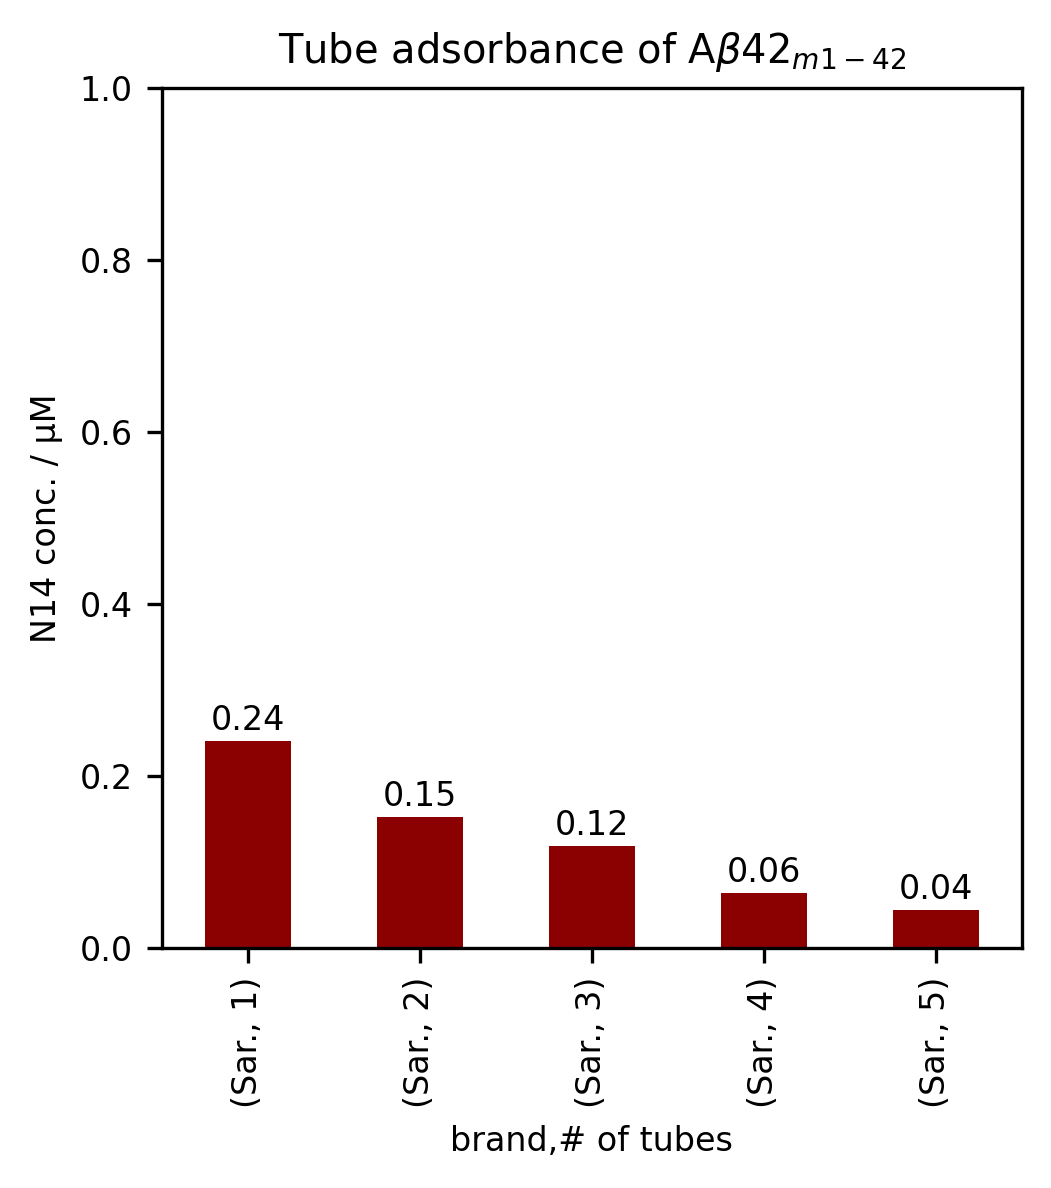

<Figure size 1800x1200 with 0 Axes>

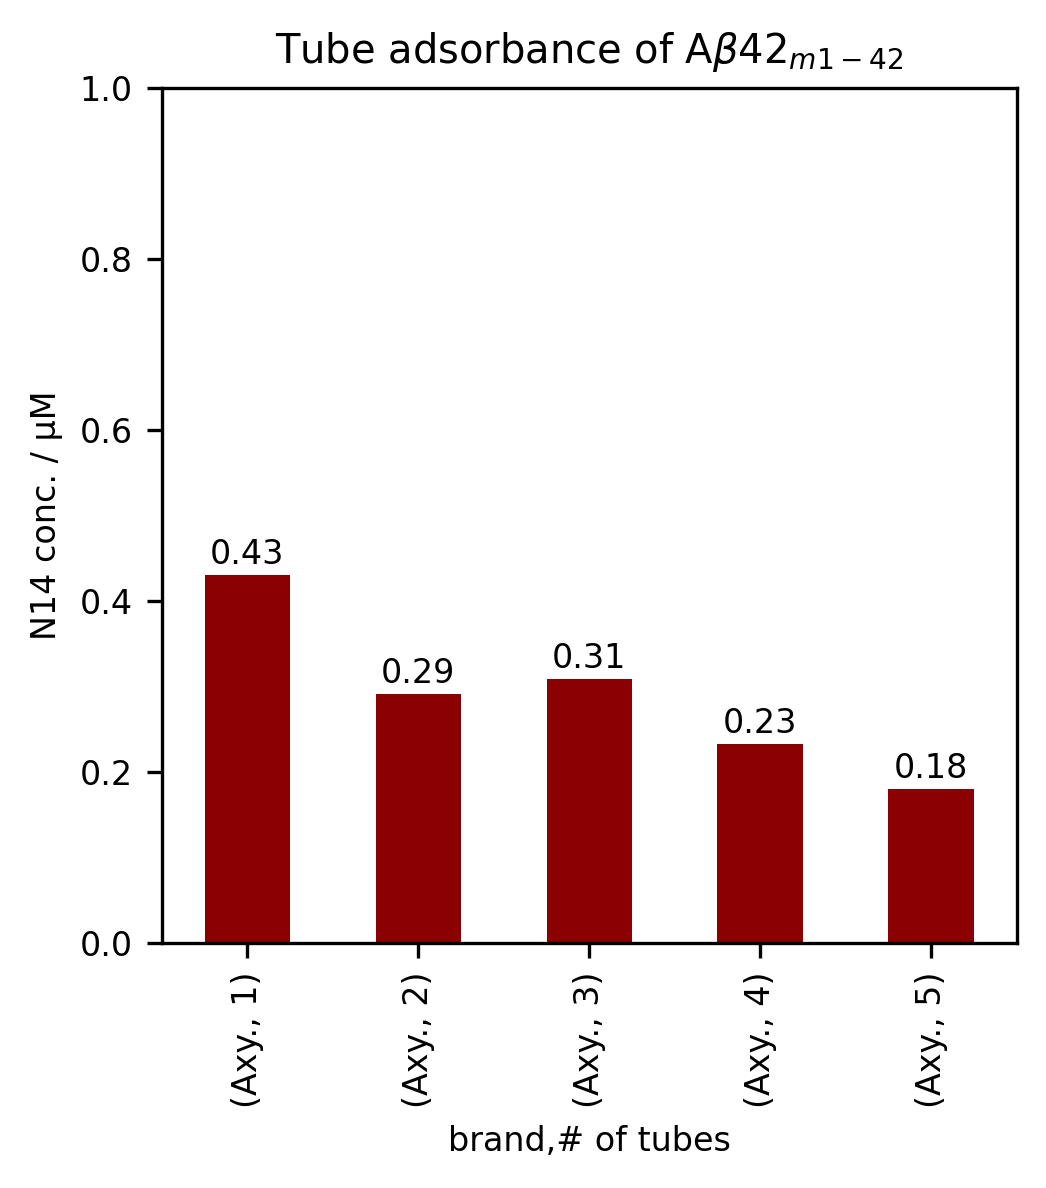

<Figure size 1800x1200 with 0 Axes>

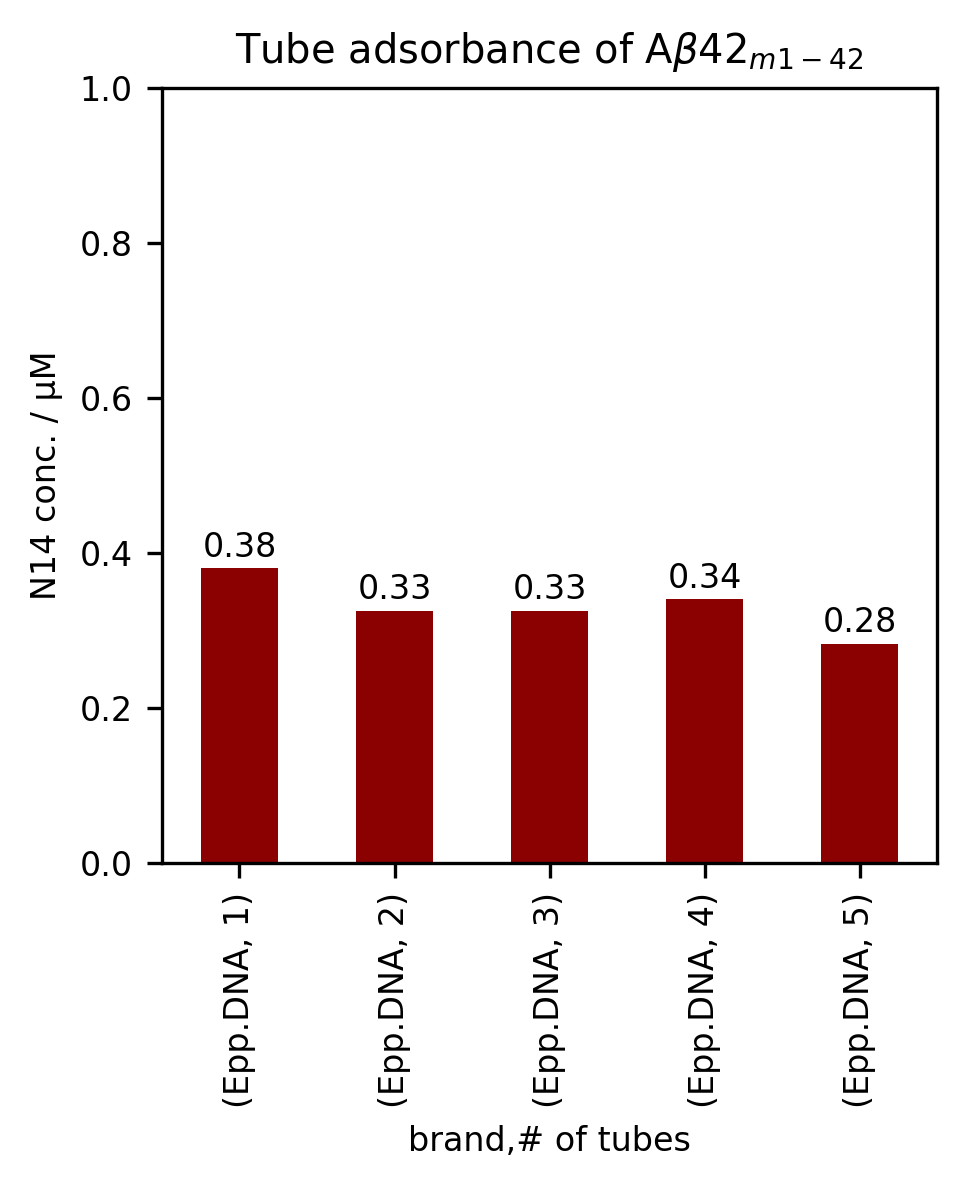

<Figure size 1800x1200 with 0 Axes>

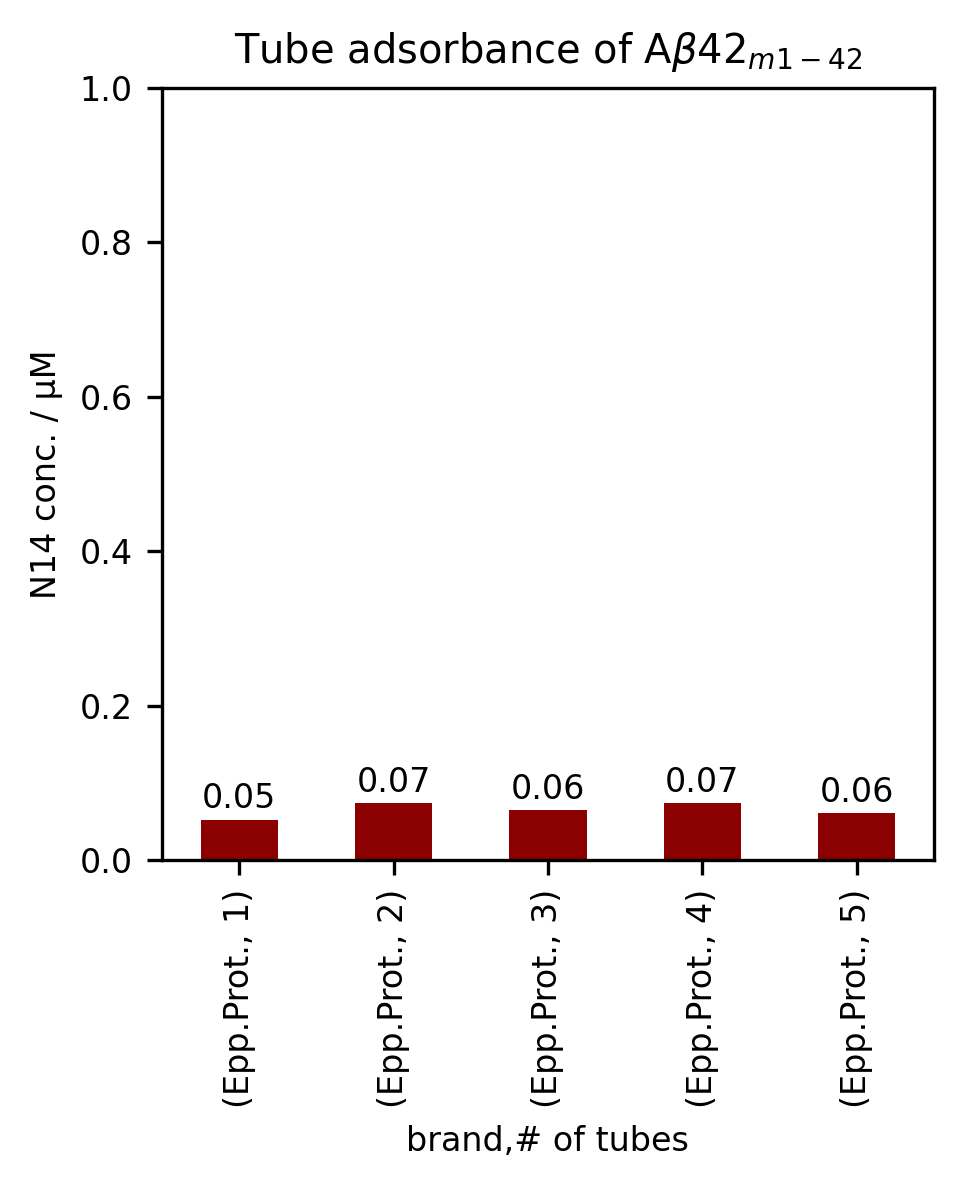

In [69]:
i=0
for x in plots:
    plotter(x,names[i],'N14 conc. / µM')
    i+=1